# Data Slopes

Analisi di una giornata sullo snowboard 🏂

In [1]:
## import librerie

## generiche
import numpy as np
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
import contextily as ctx
import datetime

## per grafici
import matplotlib.pyplot as plt
import seaborn as sns

## filtra_intersezioni
import shapely
from shapely.geometry import LineString

## scipy
import scipy.stats as sp


In [2]:
## styling

sns.set(
        style = 'whitegrid', 
        font_scale = 1.2
        )

safe_image_size= (16, 10)

In [3]:
## creazione df

df1= pd.read_csv("data/gps-22-12-2024.csv",
    usecols=[0, 1, 2, 3, 6 ,7], 
    names=["unixtime", "latitudine", "longitudine", "altitudine", "precisione_orizzontale", "precisione_verticale"] ## 
    )

df1['unixtime'] = df1['unixtime'].round(0)

## righe duplicate in unixtime
df1 = df1[df1.duplicated(subset="unixtime", keep='first') == False].reset_index(drop=True) 

## finestra temporale utile
df1 = df1[(df1['unixtime'] > 1734859000) & (df1['unixtime'] < 1734878750)].reset_index(drop=True)

## inserimento colonna per dati geospaziali
gdf_raw= gpd.GeoDataFrame(
    df1, 
    geometry= gpd.points_from_xy(df1['longitudine'], df1['latitudine']),
    crs= "EPSG:4326"  ## le coordinate usano gradi
)

gdf_raw = gdf_raw.to_crs("EPSG:3857")


In [4]:
## creazione df di supporto

df_salite= pd.read_csv("data/salite.csv")
df_discese= pd.read_csv("data/discese.csv")

df_stato = pd.concat([df_salite, df_discese])
df_stato = df_stato.sort_values(by='unixtime_start')

#gdf_raw.head(20)

#df_stato.head(10)


 ## Il dataset originale

 Composto da 3359 punti gps di cui sono noti:

- latitudine
- longitudine
- altezza in metri sul livello del mare
- precisione orizzontale
- precisone verticale

Presenta anomalie: jitter e valori anomali 

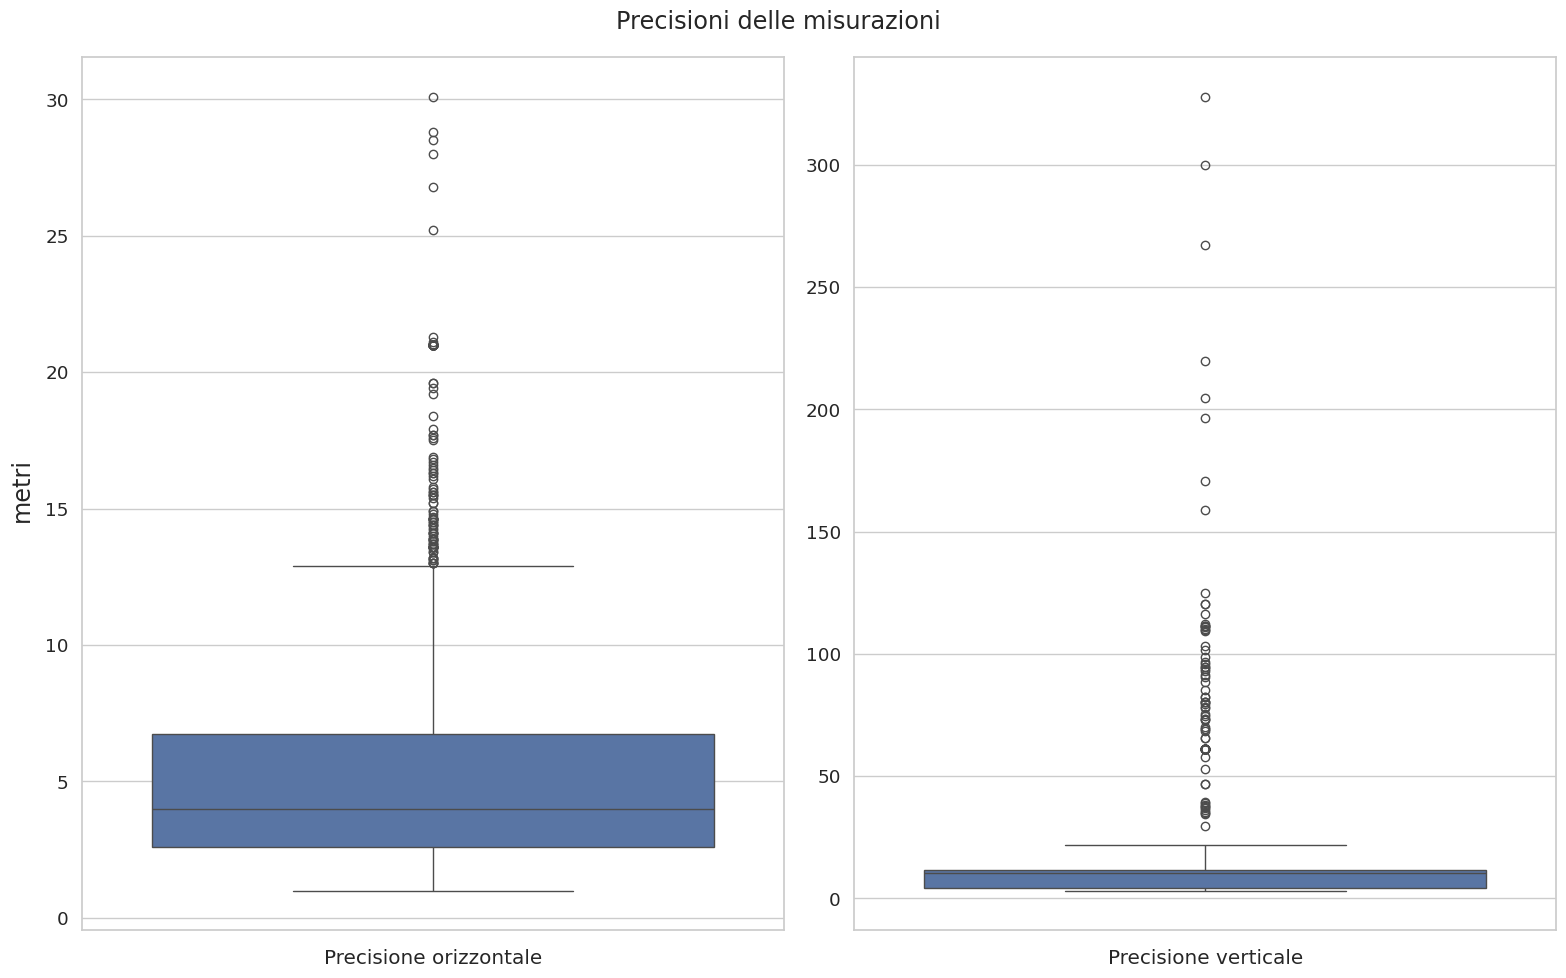

In [5]:
## grafico precisioni

gdf_raw_precisions= gdf_raw[['precisione_orizzontale', 'precisione_verticale']]

f, ax = plt.subplots(1, 2, figsize=safe_image_size)

f.suptitle("Precisioni delle misurazioni")

f.supylabel("metri")

box1= sns.boxplot(
        ax=ax[0],
        data= gdf_raw_precisions[['precisione_orizzontale']]
        )
box1.set(xticklabels=[])
ax[0].set_xlabel('Precisione orizzontale')

box2= sns.boxplot(
        ax=ax[1],
        data= gdf_raw_precisions[['precisione_verticale']]
        )
box2.set(xticklabels=[])
ax[1].set_xlabel('Precisione verticale')

plt.tight_layout() 

In [6]:
## AGGIUNTA INFORMAZIONI DERIVATE
##
##
##


## Aggiunge colonna "delta_tempo"

def aggiungi_delta_tempo(gdf):
    gdf['delta_tempo'] = abs(gdf['unixtime'].diff()).fillna(0)
    
    return gdf

def aggiungi_delta_distanze(gdf):
    ## calcola la distanza orizzontale (non tiene conto del dislivello)
    gdf['distanza_orizzontale'] = gdf.geometry.distance(gdf.geometry.shift()).fillna(0) # shift: prende punto successivo

    ## calcola la distanza verticale
    gdf['distanza_verticale'] = gdf['altitudine'].diff().fillna(0) ## positiva: sale, negativa scende

    ## calcola la distanza reale 3D usando Pitagora: i = sqrt(c1^2 + c2^2)
    gdf['distanza_reale'] = np.sqrt(
        gdf['distanza_orizzontale']**2 + (gdf['distanza_verticale'])**2
    )

    return gdf

def aggiungi_pendenza(gdf):

    gdf['pendenza'] = np.degrees(np.arctan(gdf['distanza_verticale'] / gdf['distanza_orizzontale']))
    gdf['pendenza'] = gdf['pendenza'].fillna(0)
    
    return gdf

def aggiungi_velocita(gdf):

    gdf['velocita']= (gdf['distanza_reale'] / gdf['delta_tempo']).fillna(0)

    return gdf

def aggiungi_accelerazione(gdf):

    gdf['delta_velocita'] = gdf['velocita'].diff().fillna(0)

    gdf['accelerazione'] = (gdf['delta_velocita'] / gdf['delta_tempo']).fillna(0)
    
    return gdf

def aggiungi_accelerazione_max(gdf):
    ## da gradi a radianti
    gdf['pendenza_radianti'] = np.radians(gdf['pendenza'])

    ## accelerazione massima teorica
    gdf['accelerazione_max'] = 9.81 * np.sin(gdf['pendenza_radianti'])

    return gdf

def aggiungi_distanza_percorsa(gdf):

    distanza_percorsa = [0]  
    for i in range(1, len(gdf)):
        coord1 = (gdf.iloc[i-1]['latitudine'],gdf.iloc[i-1]['longitudine'])
        coord2 = (gdf.iloc[i]['latitudine'], gdf.iloc[i]['longitudine'])
        distanza = geodesic(coord1, coord2).meters
        distanza_percorsa.append(distanza_percorsa[-1] + distanza)

    gdf['distanza_percorsa'] = distanza_percorsa

    return gdf

In [7]:
## Filtri su grandezze primarie
## Questi filtri eliminano dati in base a informazioni primaria(non derivate) nel dataframe
## Poco costosi

def filtro_precisione(gdf, precisione_orizzontale=10, precisione_verticale=10):

    gdf_filtrato = gdf.loc[
        (gdf['precisione_orizzontale'] <= precisione_orizzontale) &
        (gdf['precisione_verticale'] <= precisione_verticale)
    ].reset_index(drop=True)
    
    return gdf_filtrato

def filtra_temporalmente(gdf, min_tempo=1):

    ## lista per le righe da mantenere
    valid_rows = [0]  ## mantieni sempre il primo punto
    
    for i in range(1, len(gdf)):
        delta_tempo = gdf.iloc[i]['unixtime'] - gdf.iloc[valid_rows[-1]]['unixtime']

        if delta_tempo >= min_tempo:
            valid_rows.append(i)
    

    gdf_filtrato = gdf.iloc[valid_rows].reset_index(drop=True)
    
    return gdf_filtrato

## trova intersezioni geometriche fra punti troppo vicini
## dovrebbe eliminare jitter jps 
def filtro_intersezioni(gdf, max_time_diff=60*1):

    punti_da_rimuovere = []  ## Lista per i punti da rimuovere
    segmenti = [] ## i segmenti che uniscono 2 punti

    ## crea segmenti
    for i in range(len(gdf) - 1):
        ## un segmento è fatto dal punto d'inizio e il punto di fine con relativi timestamp
        punto1 = (gdf.loc[i, "longitudine"], gdf.loc[i, "latitudine"])
        punto2 = (gdf.loc[i + 1, "longitudine"], gdf.loc[i + 1, "latitudine"])
        tempo1 = gdf.loc[i, "unixtime"]
        tempo2 = gdf.loc[i + 1, "unixtime"]

        ## il segmento diventa un tipo LineString
        segmento = LineString([punto1, punto2])

        ## aggiunge il segmento con i timestamp e gli indici
        segmenti.append((   segmento, 
                            tempo1, 
                            tempo2, 
                            i, 
                            i + 1)) 

    ## controlla le intersezioni
    for i in range(len(segmenti)):
        j = i + 2   ## partiamo dal segmento successivo, 
                    ## 2 punti più in la per evitare intersezioni in un punto singolo!!!

        while j < len(segmenti) and abs(segmenti[i][2] - segmenti[j][1]) <= max_time_diff:  
            segmento1 = segmenti[i][0]  ## il primo valore della tupla è un segmento
            segmento2 = segmenti[j][0]  

            if segmento1.intersects(segmento2):  ## se si intersecano
                punti_da_rimuovere.append(segmenti[i][4])  ## elimina i punti di indice i e j
                #punti_da_rimuovere.append(segmenti[j][3])  ## [3]: i [4]:i+1 

            j += 1  # Passa al segmento successivo
            ##if
        ##while
    ##for
    ## segmenti intersecanti trovati

    gdf = gdf.drop(punti_da_rimuovere).reset_index(drop=True)

    return gdf


In [8]:
## filtra il df in base ai limiti fisici delle grandezze derivate. 
## COSTOSO

def filtra_df(gdf_orig, min_acc=-4, max_acc=4):

    gdf=gdf_orig.copy() ## gdf.loc[]...

    cambiato = True
    while cambiato:

        gdf = aggiungi_delta_tempo(gdf)
        gdf = aggiungi_delta_distanze(gdf)
        gdf = aggiungi_pendenza(gdf)
        gdf = aggiungi_velocita(gdf)
        gdf = aggiungi_accelerazione(gdf)
        gdf = aggiungi_accelerazione_max(gdf)
        
        lunghezza_pre = len(gdf)
        ## Filtra per accelerazione
        gdf = gdf[(gdf['accelerazione'] >= min_acc) & (gdf['accelerazione'] <= max_acc)]

        lunghezza_post = len(gdf)
        # Se sono state eliminate righe, ripeti il ciclo
        if lunghezza_post < lunghezza_pre:
            cambiato = True
        else:
            cambiato = False

    return gdf

In [9]:
## Filtri dati primari dataset

gdf1 = filtro_precisione(gdf_raw, precisione_orizzontale=20, precisione_verticale= 20)

gdf1= filtro_intersezioni(gdf1, max_time_diff=60*1)

In [10]:
## Inserimento di grandezze derivate

gdf1 = aggiungi_delta_tempo(gdf1)

gdf1= aggiungi_delta_distanze(gdf1)

gdf1= aggiungi_pendenza(gdf1)

gdf1= aggiungi_velocita(gdf1)

gdf1 = aggiungi_accelerazione(gdf1)

gdf1= aggiungi_accelerazione_max(gdf1)

gdf1= aggiungi_distanza_percorsa(gdf1)

In [11]:
## Filtro in base alla fisica su grandezze derivate

gdf1= filtra_df(gdf1, min_acc=-3, max_acc=3)

#gdf1.describe()
#gdf1.head()

In [12]:
time_start = gdf1['unixtime'].iloc[0]
time_end = gdf1['unixtime'].iloc[-1]

time_delta= time_end - time_start

tempo_trascorso_hms = str(datetime.timedelta(seconds=time_delta))
#print(tempo_trascorso_hms)

gdf1['time_from_start']= gdf1['unixtime'] - time_start


In [13]:
## aggiunge ad ogni punto la sua categorizzazione

gdf1['stato'] = 'Altro'

for index, row in df_stato.iterrows(): ## (index, row(Series) )

    mask = (gdf1['unixtime'] >= row['unixtime_start']) & (gdf1['unixtime'] <= row['unixtime_end'])
    ## mask         : Serie bool che funge da condizione
    ## 'stato'      : colonna in cui modificare i dati
    ## row['stato'] : valore da inserire 

    stato= row['stato']

    gdf1.loc[mask, 'stato'] = stato

#gdf1.head()

## Il dataset finale

Composto da 3043 punti gps **originali** a cui sono state aggiunte le informazioni relative a:

- scarto temporale
- velocità
- accelerazione
- distanza fra punti
- ...

Il filtraggio dei dati:

- precisione musurazioni ($\pm$ 20 metri)
- intersezione fra segmenti temporalmente vicini (1 minuto )
- limiti fisici di accelerazione ($\pm$ 3 m/s)

Questi dati sono più attendibili

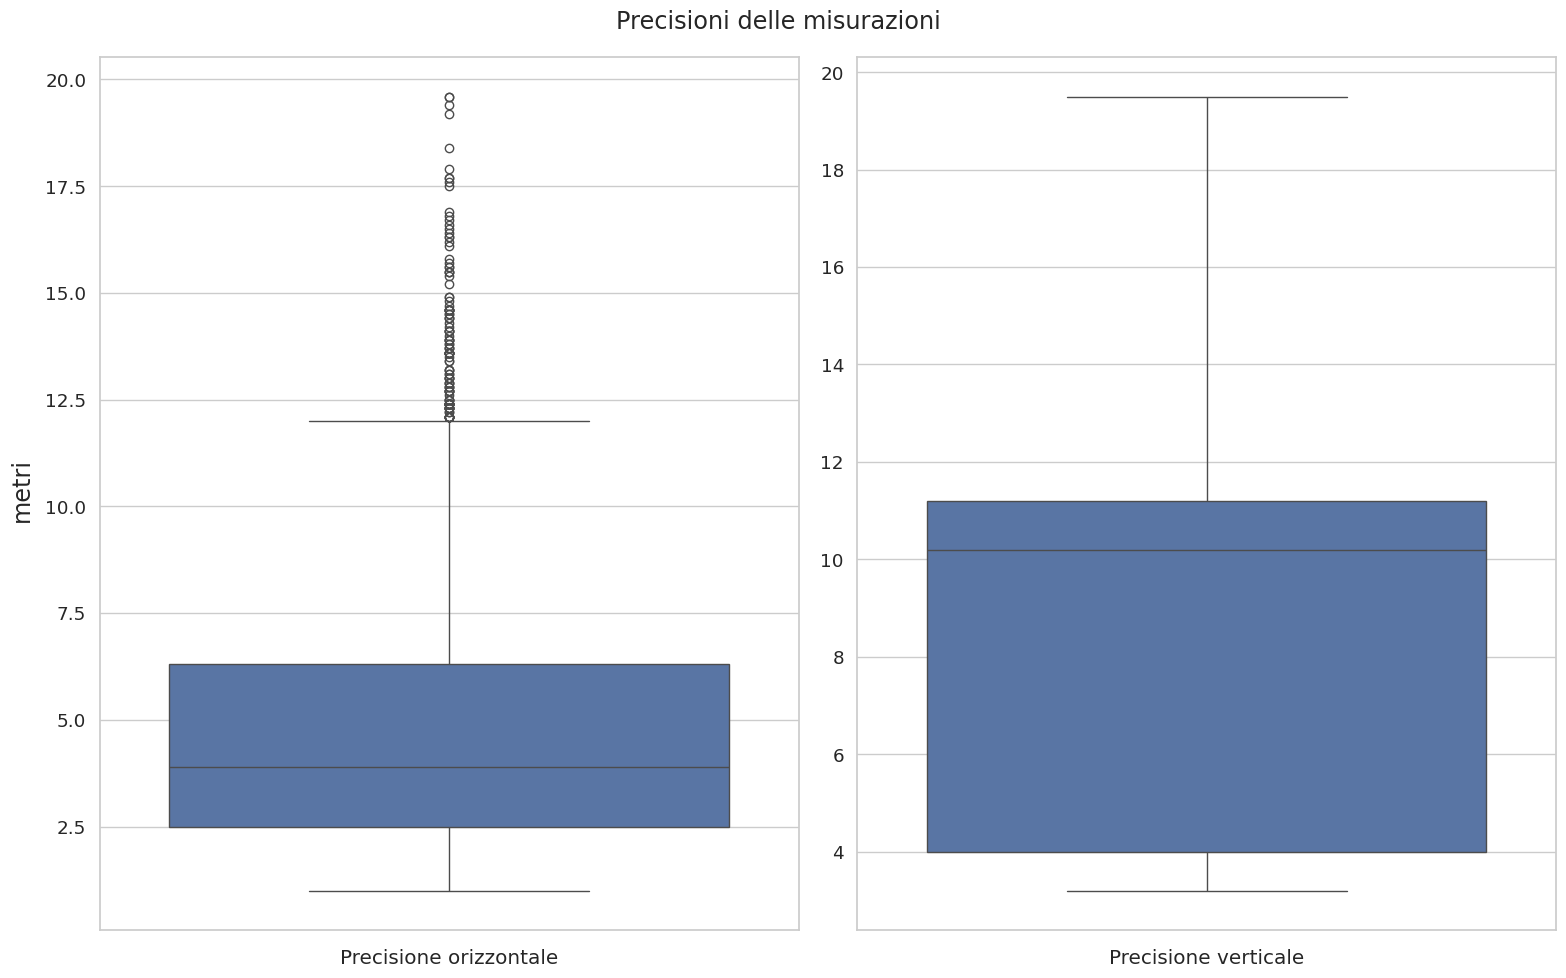

In [14]:
## grafico precisioni

gdf1_precisioni= gdf1[['precisione_orizzontale', 'precisione_verticale']]

f, ax = plt.subplots(1, 2, figsize=safe_image_size)

f.suptitle("Precisioni delle misurazioni")

f.supylabel("metri")

box1= sns.boxplot(
        ax=ax[0],
        data= gdf1_precisioni[['precisione_orizzontale']]
        )
box1.set(xticklabels=[])
ax[0].set_xlabel('Precisione orizzontale')

box2= sns.boxplot(
        ax=ax[1],
        data= gdf1_precisioni[['precisione_verticale']]
        )
box2.set(xticklabels=[])
ax[1].set_xlabel('Precisione verticale')

plt.tight_layout() 

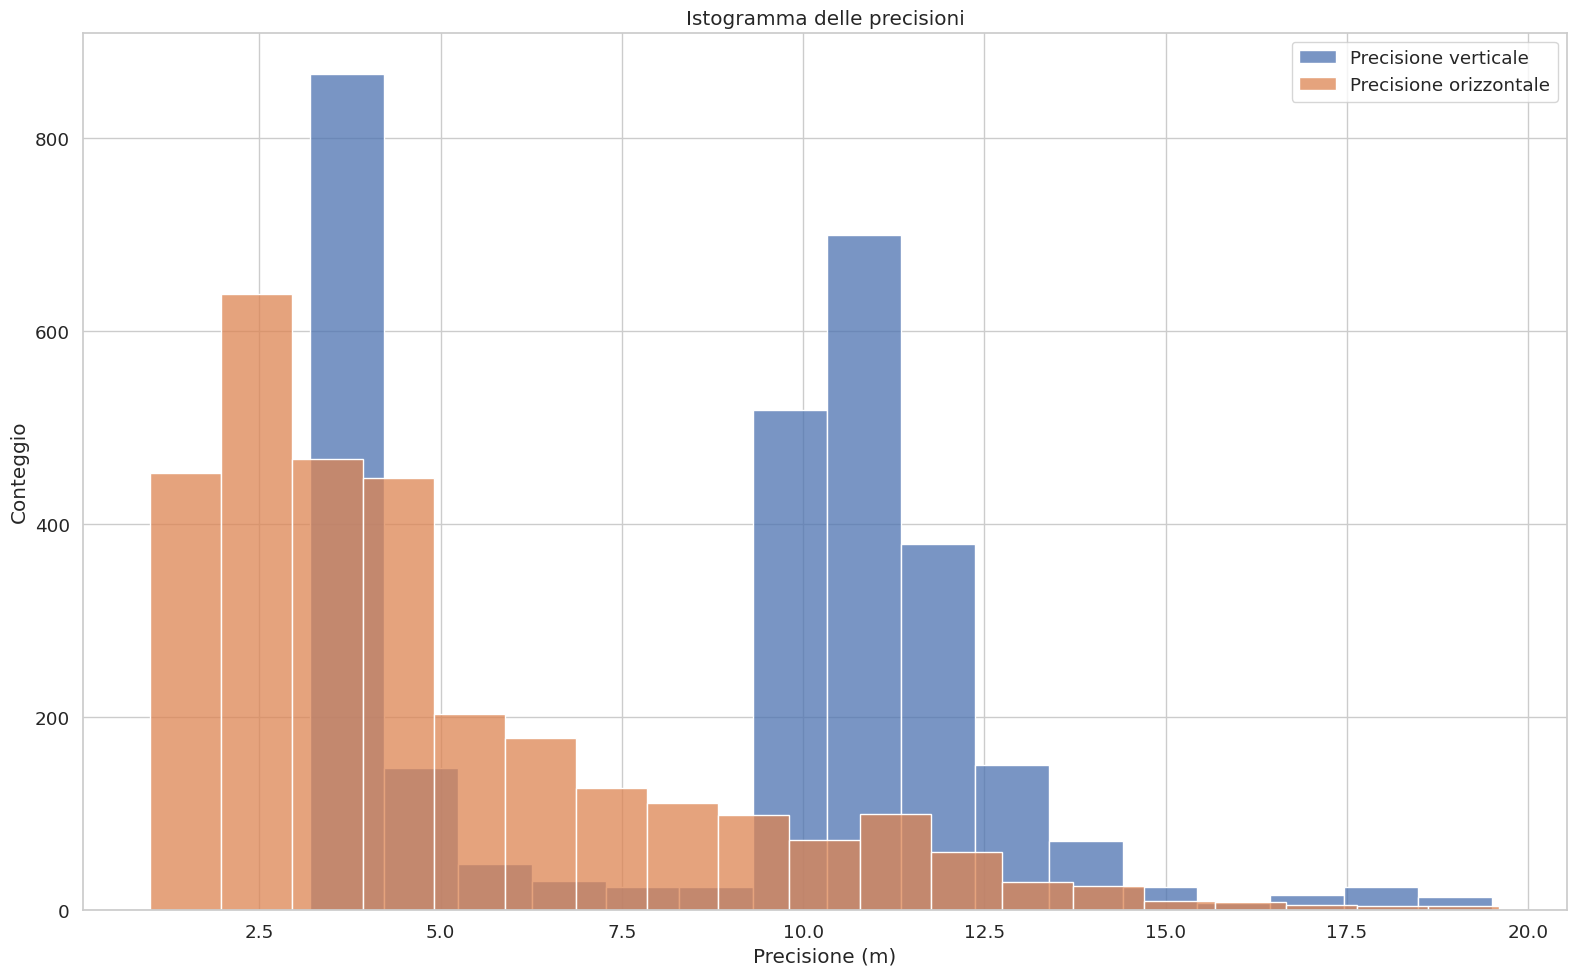

In [15]:
f, ax = plt.subplots(1, 1, figsize=safe_image_size)

ax.set_title("Istogramma delle precisioni")

sns.histplot(
    ax=ax,
    data= gdf1_precisioni['precisione_verticale'],
    label= "Precisione verticale",
    binwidth= 1
    )

sns.histplot(
    ax=ax,
    data= gdf1_precisioni['precisione_orizzontale'],
    label= "Precisione orizzontale",
    binwidth= 1
    )

ax.set_ylabel("Conteggio")
ax.set_xlabel("Precisione (m)")
ax.legend()

plt.tight_layout()
plt.show()

## Com'è andata la giornata?

### Il profilo di giornata

Ho registrato 10 discese in un periodo di circa 5 ore e mezza (5:28:21), accumulando una verticale di 4387 metri di discesa.

In [16]:
#gdf1.head()

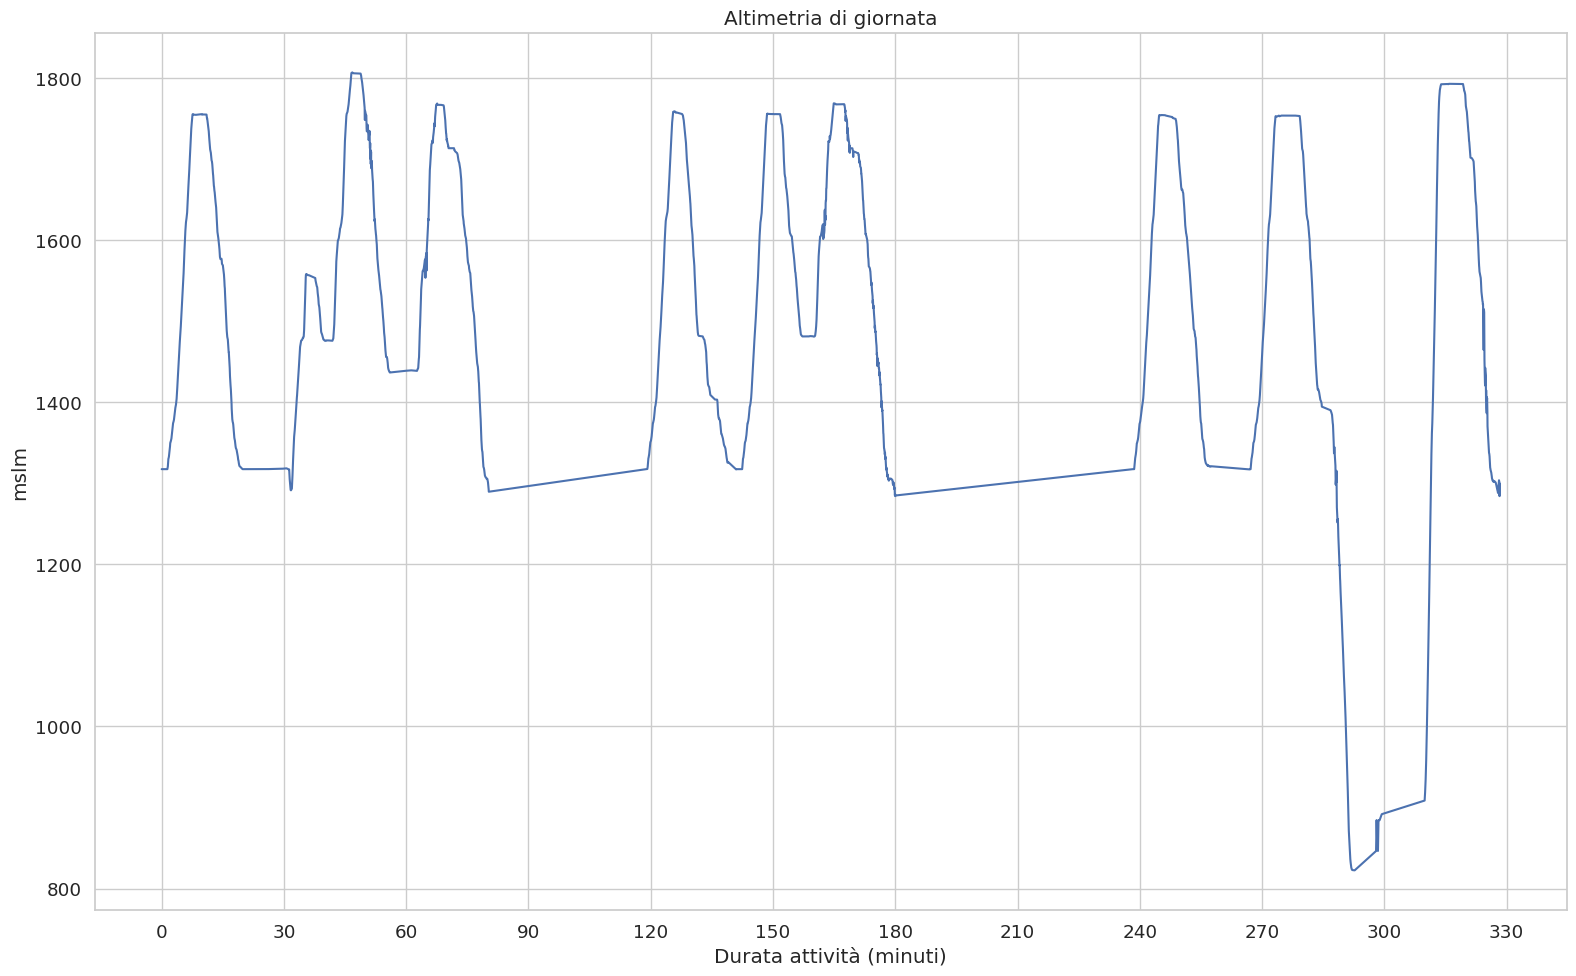

In [17]:
## Altimetria della giornata
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________


gdf1_altitudine= gdf1[['time_from_start', 'altitudine']].copy()

gdf1_altitudine['time_from_start_minuti'] = gdf1_altitudine['time_from_start'] / 60

gdf1_altitudine.head()


f, ax = plt.subplots(1, 1, figsize=safe_image_size)

ax.set_title("Altimetria di giornata")

sns.lineplot(
    ax=ax,
    data=gdf1_altitudine,
    y="altitudine",
    x="time_from_start_minuti"
    )

ax.set_ylabel("mslm")
ax.set_xlabel("Durata attività (minuti)")

## serve a settare i ticks ogni 30 min
maxtime= gdf1_altitudine['time_from_start_minuti'].max()
ticks = range(0,  int(maxtime) + 5, 30)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

plt.tight_layout()
plt.show()


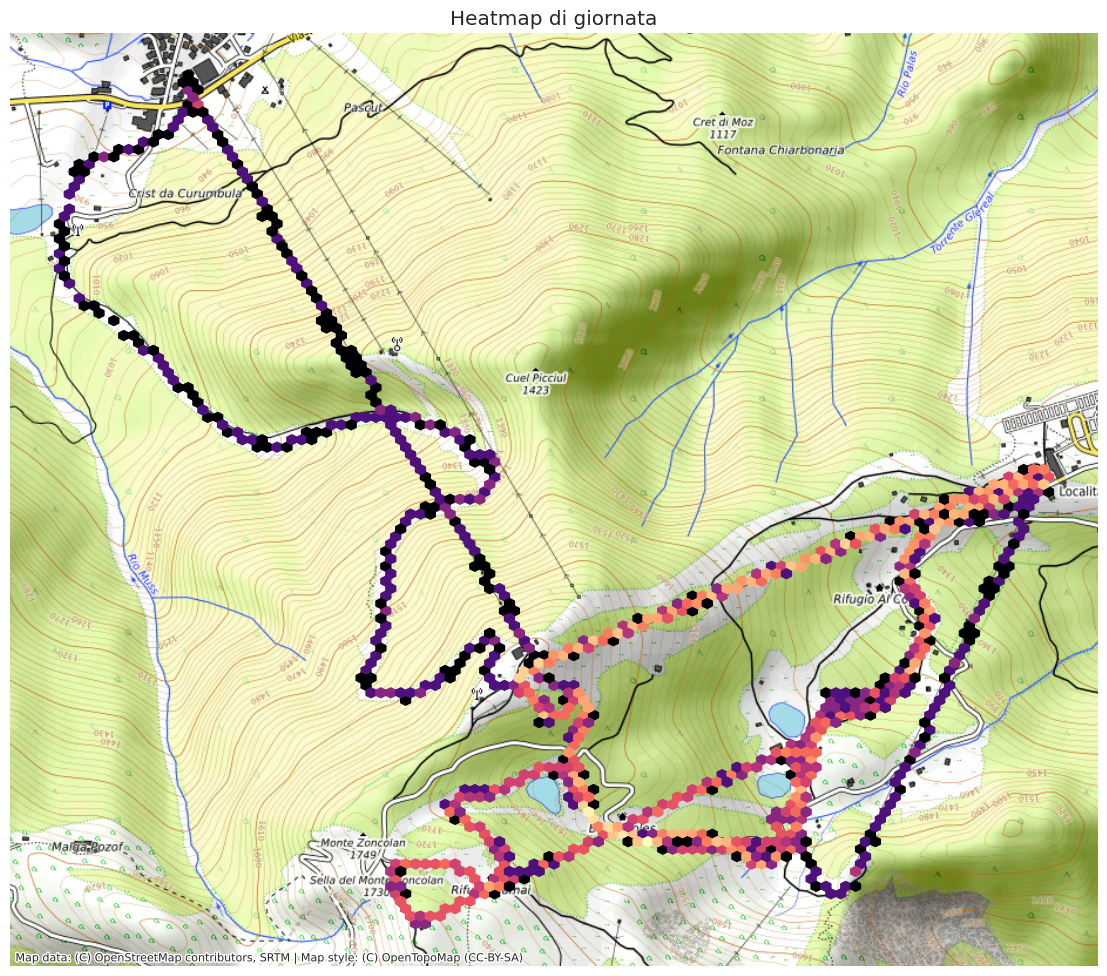

In [18]:
f, ax = plt.subplots(figsize=safe_image_size)

ax.set_title("Heatmap di giornata")

ax.hexbin(
    gdf1.geometry.x, 
    gdf1.geometry.y,
    cmap='magma',
    norm='log', ##
    alpha= 1
    )


ctx.add_basemap(ax=ax, 
                source=ctx.providers.OpenTopoMap # OpenStreetMap.Mapnik #OpenTopoMap #https://contextily.readthedocs.io/en/latest/providers_deepdive.html
                )

ax.set_axis_off()
ax.set_aspect('equal') ## non distorce mappa

plt.tight_layout()

plt.show()


In [19]:
#gdf1.head()

### Uso del tempo

La giornata è stata divisa in scaglioni temporali etichettati in base all'attività.

- le risalite hanno il nome delle funivie :
  - Cuel D'ajar
  - Valvan
  - Giro d'Italia
  - Ravascletto
- le discese non hanno un nome: le piste offrono molte varianti!
- la classificazione "Altro" comprende il tempo utilizzato per:
  - mangiare
  - spostarsi fra gli impianti di risalita
  - tempo in coda

In [20]:
## Analisi temporale


In [21]:
tempo_per_stato = gdf1.groupby('stato')['delta_tempo'].sum().reset_index()
tempo_per_stato.columns = ['stato', 'tempo_totale_secondi']

conteggio_stati = df_stato['stato'].value_counts().reset_index()
conteggio_stati.columns= [ 'stato', 'conteggio']


tempo_per_stato = pd.merge(
                tempo_per_stato, conteggio_stati,
                on= 'stato',
                how= 'left', ## mantiene la colonna 'Altro'
                ).fillna(1) ## colonna 'Altro' -> Nan -> 1

tempo_per_stato['tempo_medio_secondi'] = tempo_per_stato['tempo_totale_secondi'] / tempo_per_stato['conteggio']

tempo_per_stato['tempo_totale_minuti'] = tempo_per_stato['tempo_totale_secondi'] / 60
tempo_per_stato['tempo_medio_minuti'] = tempo_per_stato['tempo_totale_secondi'] / 60


tempo_per_stato.sort_values(by='tempo_totale_secondi', inplace= True)
#tempo_per_stato.head(20)

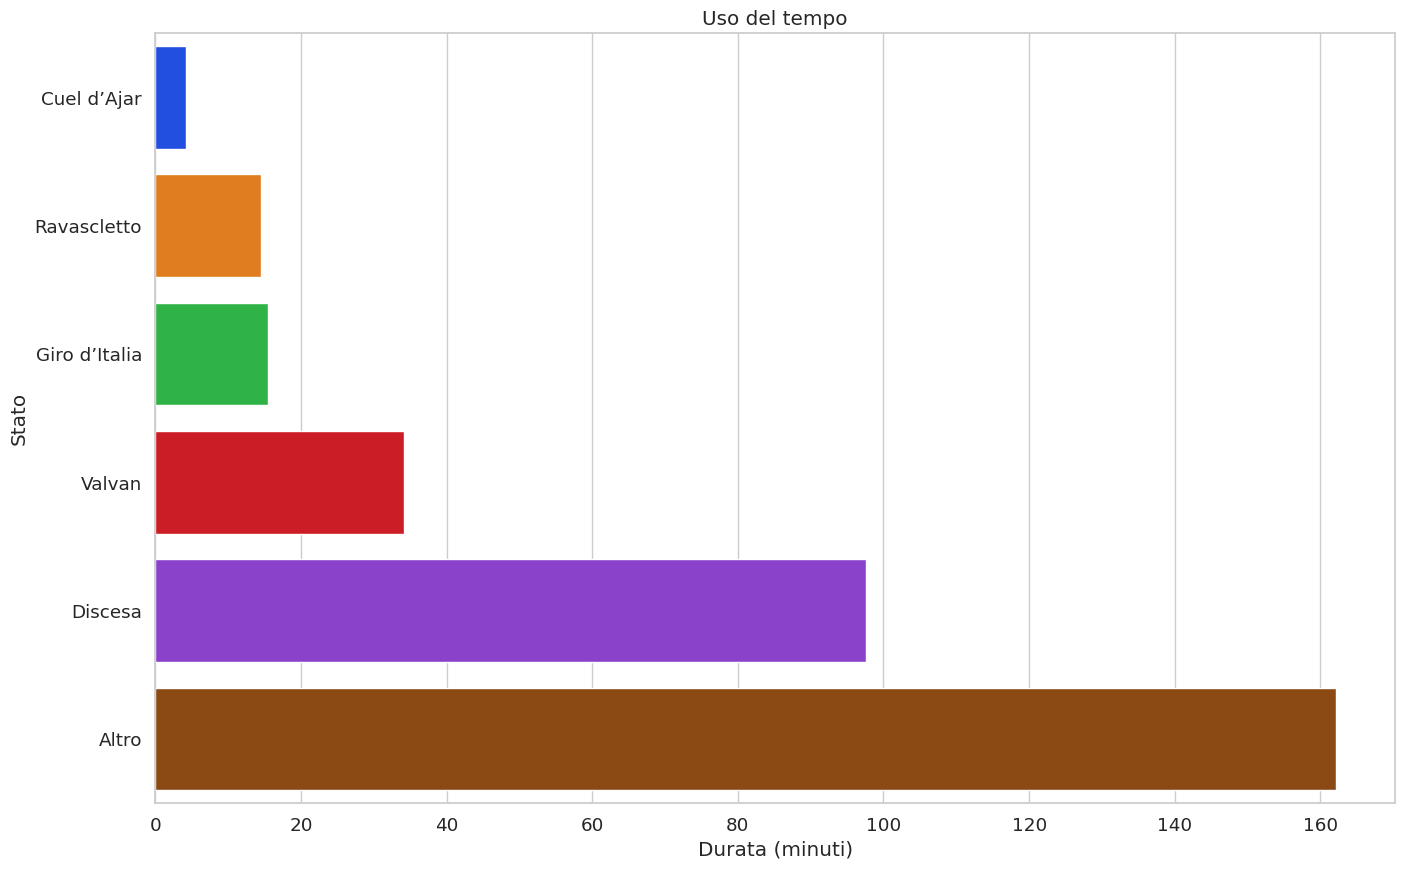

In [22]:
f, ax = plt.subplots(1, 1, figsize=safe_image_size)

ax.set_title("Uso del tempo")

sns.barplot(
            data=tempo_per_stato,
            y="stato", 
            x="tempo_totale_minuti",
            orient='h',
            hue='stato',
            palette= 'bright'
            )
            
ax.set_ylabel("Stato")
ax.set_xlabel("Durata (minuti)")

plt.show()

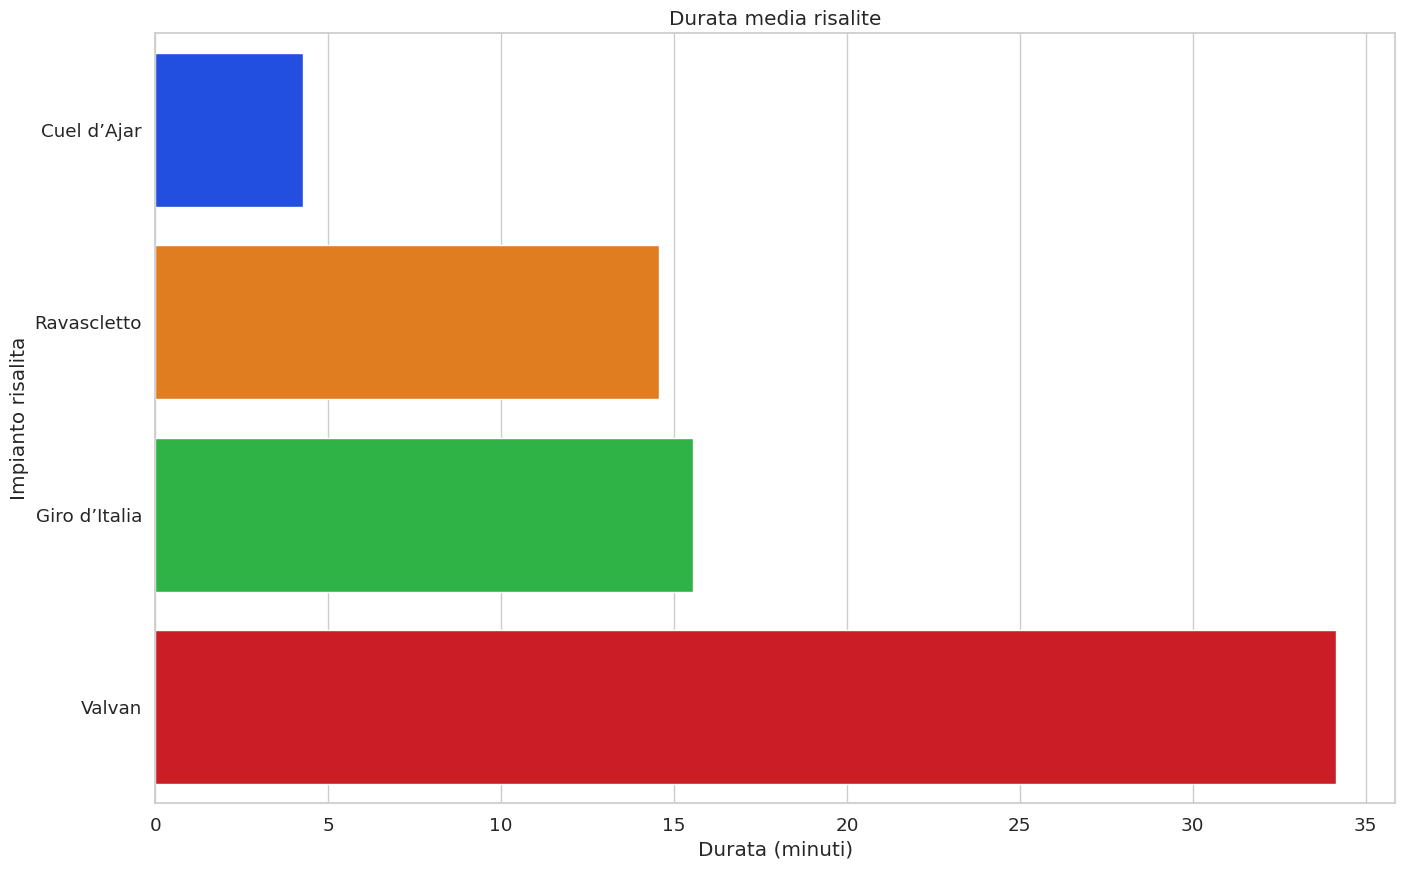

In [23]:
tempo_per_stato_salite= tempo_per_stato[(tempo_per_stato['stato'] != 'Altro') & (tempo_per_stato['stato'] != 'Discesa') ]


f, ax = plt.subplots(1, 1, figsize=safe_image_size)

ax.set_title("Durata media risalite")

sns.barplot(
            data=tempo_per_stato_salite,
            y="stato", 
            x="tempo_medio_minuti",
            orient='h',
            hue='stato',
            palette= 'bright'
            )
            
ax.set_ylabel("Impianto risalita")
ax.set_xlabel("Durata (minuti)")

plt.show()

Non sembro una persona molto sportiva: 

- Il 49.4% del tempo (2:42:10) è stato impiegato per fare altro
- Il 29.7% del tempo (1:37:38) è stato impiegato per scendere sulle piste
- Il 22.7% del tempo (1:08:33) è stato impiegato per salire sugli impianti


### Le risalite

Ho utilizzato 4 impinanti di risalita:

- Valvan 5 volte
- Ravascletto 1 volta
- Giro d'Italia 3 volte
- Cuel D'Ajar 1 volta

Tempi medi per risalita:

- Valvan: 0:06:49
- Ravascletto: 0:14:34
- Giro d'Italia: 0:05:11
- Cuel D'Ajar: 0:04:17

### Le discese

Durante la giornata ho effettuato 10 discese: 8 diverse e 2 ripetute.

In [24]:
## aggiunge statistiche di discesa
velocita_medie_discese= []
velocita_max_discese= []
velocita_mediane_discese= []
distanza_discesa= []


for idx, row in df_discese.iterrows():

    discesa_data= gdf1[(gdf1['unixtime'] >= row['unixtime_start']) & 
                        (gdf1['unixtime'] <= row['unixtime_end'])]
    
    velocita_media= discesa_data['velocita'].mean() * 3.6
    velocita_mediana= discesa_data['velocita'].median() * 3.6
    velocita_max= discesa_data['velocita'].max() * 3.6
    distanza_totale= discesa_data['distanza_reale'].sum()
    

    
    velocita_medie_discese.append(velocita_media)
    velocita_max_discese.append(velocita_max)
    velocita_mediane_discese.append(velocita_mediana)
    distanza_discesa.append(distanza_totale)


df_discese['velocita_media']= velocita_medie_discese
df_discese['velocita_mediana']= velocita_mediane_discese
df_discese['velocita_max']= velocita_max_discese
df_discese['distanza_discesa']= distanza_discesa


crociera= df_discese['velocita_mediana'].median()

#print(crociera)

velocita_max= gdf1['velocita'].max()* 3.6
#print(velocita_max)

In [25]:
df_discese.head(10)

unixtime_start  unixtime_end    stato                nome impianto_inizio  \
0      1734859650    1734860191  Discesa          Zoncolan 4          Valvan   
1      1734861215    1734861429  Discesa          Zoncolan 4     Cuel D'Ajar   
2      1734861976    1734862398  Discesa          Zoncolan 4   Giro d'Italia   
3      1734863200    1734863863  Discesa  Goles + Zoncolan 4   Giro d'Italia   
4      1734866632    1734867373  Discesa          Zoncolan 4          Valvan   
5      1734868080    1734868459  Discesa          Zoncolan 4          Valvan   
6      1734869099    1734869850  Discesa  Goles + Zoncolan 4   Giro d'Italia   
7      1734873926    1734874470  Discesa          Zoncolan 4          Valvan   
8      1734875805    1734876610  Discesa               Lavet          Valvan   
9      1734878215    1734878745  Discesa          Zoncolan 4     Ravascletto   

   impianto_fine  velocita_media  velocita_mediana  velocita_max  \
0    Cuel D'Ajar       35.257606         33.647631     80.051762   
1  Giro d'Italia       30.564554         29.280866     60.241939   
2  Giro d'Italia       31.413453         28.836925     69.234315   
3         Valvan       33.793684         34.892846     66.836088   
4         Valvan       32.036171         33.197047     57.009107   
5  Giro d'Italia       29.623457         28.607321     54.017769   
6         Valvan       31.210053         31.783959     57.026005   
7         Valvan       31.662379         31.728483     66.726945   
8   Ravasacletto       40.058309         36.117424     92.360169   
9         valvan       35.839775         36.648083     63.834759   

   distanza_discesa  
0       4053.213838  
1        824.550079  
2       3290.772891  
3       4855.259259  
4       4046.136367  
5       2275.961053  
6       4993.834560  
7       3977.689368  
8       5450.769682  
9       4101.183405

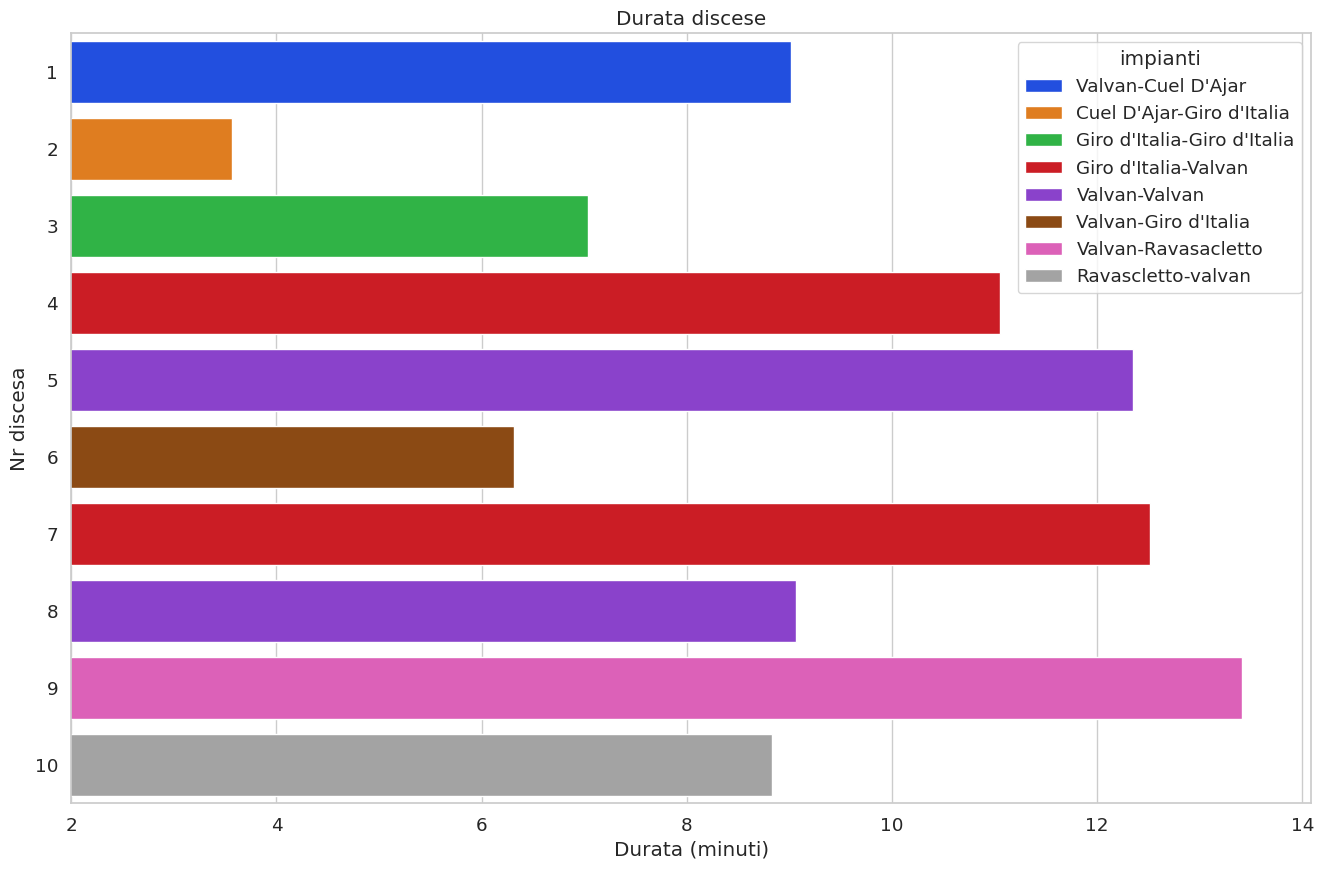

In [26]:
df_discese['impianti'] = df_discese['impianto_inizio'] + "-" + df_discese['impianto_fine']
df_discese['tempo_discesa'] = (df_discese['unixtime_end'] - df_discese['unixtime_start']) /60

f, ax = plt.subplots(1, 1, figsize=safe_image_size)

ax.set_title("Durata discese")

sns.barplot(
            data=df_discese,
            y=df_discese.index +1, 
            x="tempo_discesa",
            orient='h',
            hue='impianti',
            palette= 'bright',
            )

ax.set_xlim(2, None)
            
ax.set_ylabel("Nr discesa")
ax.set_xlabel("Durata (minuti)")

plt.show()


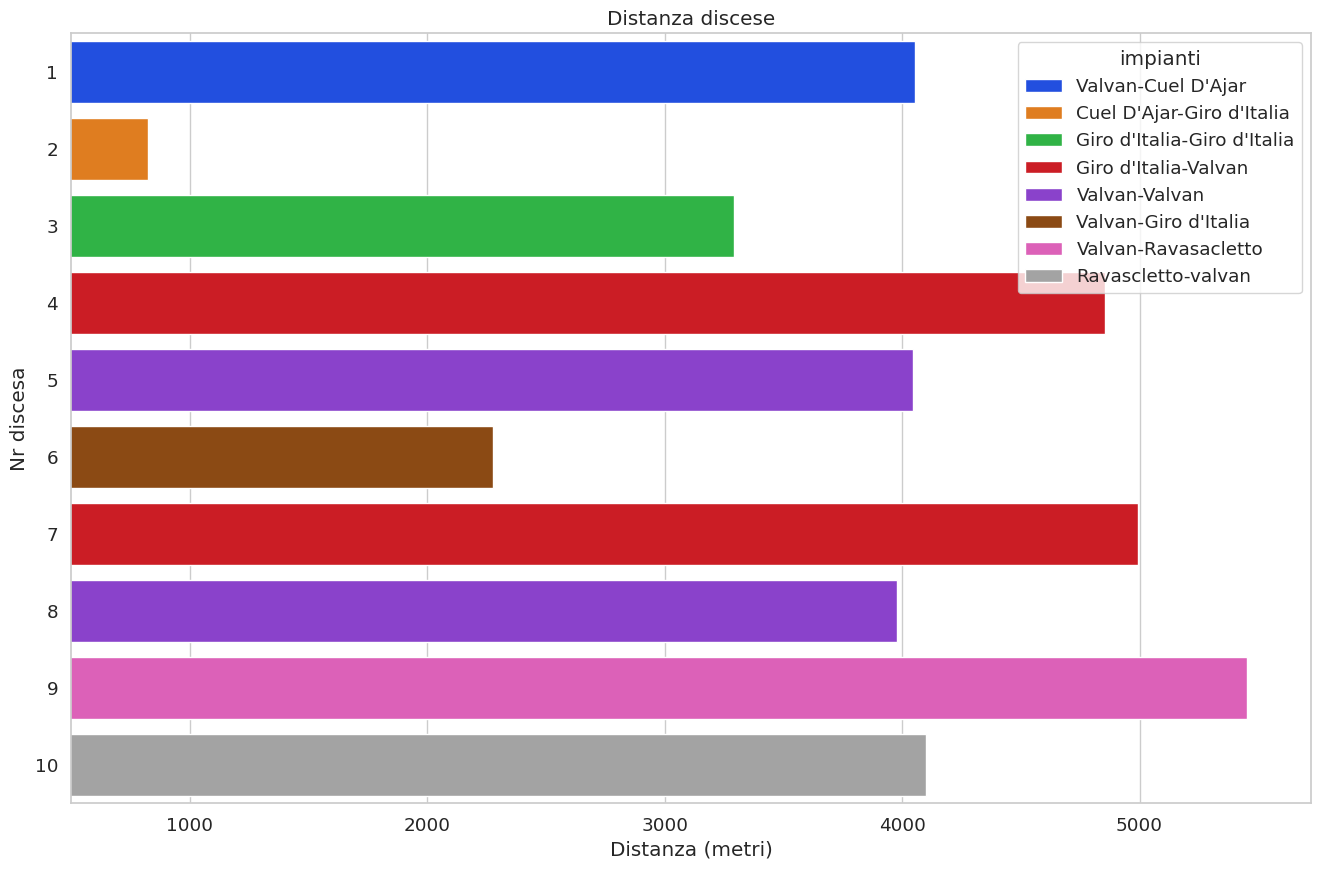

In [27]:


f, ax = plt.subplots(1, 1, figsize=safe_image_size)

ax.set_title("Distanza discese")

sns.barplot(
            data=df_discese,
            y=df_discese.index +1, 
            x="distanza_discesa",
            orient='h',
            hue='impianti',
            palette= 'bright',
            )

ax.set_xlim(500, None)

ax.set_ylabel("Nr discesa")
ax.set_xlabel("Distanza (metri)")

plt.show()


- Il tempo medio di una discesa è 09:45.8 ⏱️
- Una velocità  mediana: 32 km/h 🦥


## Dov'è possibile raggiungere la velocità massima?

La velocità massima è di 92 km/h 🪖

In [28]:
## elimino tempi morti

gdf_discese= gdf1[gdf1['stato'] == 'Discesa']

gdf_discese

unixtime  latitudine  longitudine   altitudine  \
132   1.734860e+09   46.506102    12.932139  1754.914113   
133   1.734860e+09   46.506047    12.932252  1754.809588   
135   1.734860e+09   46.505903    12.932426  1752.475198   
136   1.734860e+09   46.505864    12.932548  1750.189586   
137   1.734860e+09   46.505811    12.932657  1750.178227   
...            ...         ...          ...          ...   
3102  1.734879e+09   46.511273    12.950366  1303.690046   
3103  1.734879e+09   46.511328    12.950500  1301.747050   
3104  1.734879e+09   46.511384    12.950678  1301.478326   
3105  1.734879e+09   46.511430    12.950827  1284.102881   
3106  1.734879e+09   46.511472    12.950971  1299.540247   

      precisione_orizzontale  precisione_verticale  \
132                      3.9                  10.1   
133                      4.4                  11.3   
135                      5.0                  16.9   
136                      4.5                  16.9   
137                      4.8                  17.5   
...                      ...                   ...   
3102                     6.7                   3.8   
3103                    13.1                   3.8   
3104                     7.4                   3.8   
3105                    11.7                   3.8   
3106                     7.8                   3.8   

                             geometry  delta_tempo  distanza_orizzontale  \
132    POINT (1439599.128 5861826.69)          6.0             14.470630   
133   POINT (1439611.707 5861817.795)         57.0             15.406612   
135   POINT (1439631.077 5861794.505)          4.0             30.291988   
136   POINT (1439644.658 5861788.197)          3.0             14.974310   
137   POINT (1439656.792 5861779.625)          3.0             14.856267   
...                               ...          ...                   ...   
3102  POINT (1441628.149 5862663.069)         15.0             15.858140   
3103  POINT (1441643.066 5862671.965)          3.0             17.368257   
3104   POINT (1441662.88 5862681.023)          3.0             21.787117   
3105  POINT (1441679.467 5862688.464)          2.0             18.179053   
3106  POINT (1441695.497 5862695.257)          2.0             17.410172   

      distanza_verticale  distanza_reale   pendenza   velocita  \
132             0.220069       14.472304   0.871286   2.412051   
133            -0.104525       15.406966  -0.388713   0.270298   
135            -2.334390       30.381802  -4.406672   7.595451   
136            -2.285612       15.147739  -8.678391   5.049246   
137            -0.011359       14.856271  -0.043808   4.952090   
...                  ...             ...        ...        ...   
3102           15.599244       22.244483  44.528463   1.482966   
3103           -1.942996       17.476601  -6.383169   5.825534   
3104           -0.268724       21.788774  -0.706655   7.262925   
3105          -17.375445       25.147248 -43.705213  12.573624   
3106           15.437366       23.268570  41.562975  11.634285   

      delta_velocita  accelerazione  pendenza_radianti  accelerazione_max  \
132         0.164363       0.027394           0.015207           0.149173   
133        -2.141753      -0.037575          -0.006784          -0.066554   
135         7.325153       1.831288          -0.076911          -0.753753   
136        -2.546204      -0.848735          -0.151466          -1.480211   
137        -0.097156      -0.032385          -0.000765          -0.007501   
...              ...            ...                ...                ...   
3102       -4.077625      -0.271842           0.777168           6.879395   
3103        4.342568       1.447523          -0.111407          -1.090646   
3104        1.437391       0.479130          -0.012333          -0.120988   
3105        5.310699       2.655350          -0.762800          -6.778202   
3106       -0.939339      -0.469669           0.725411           6.508374   

      dis

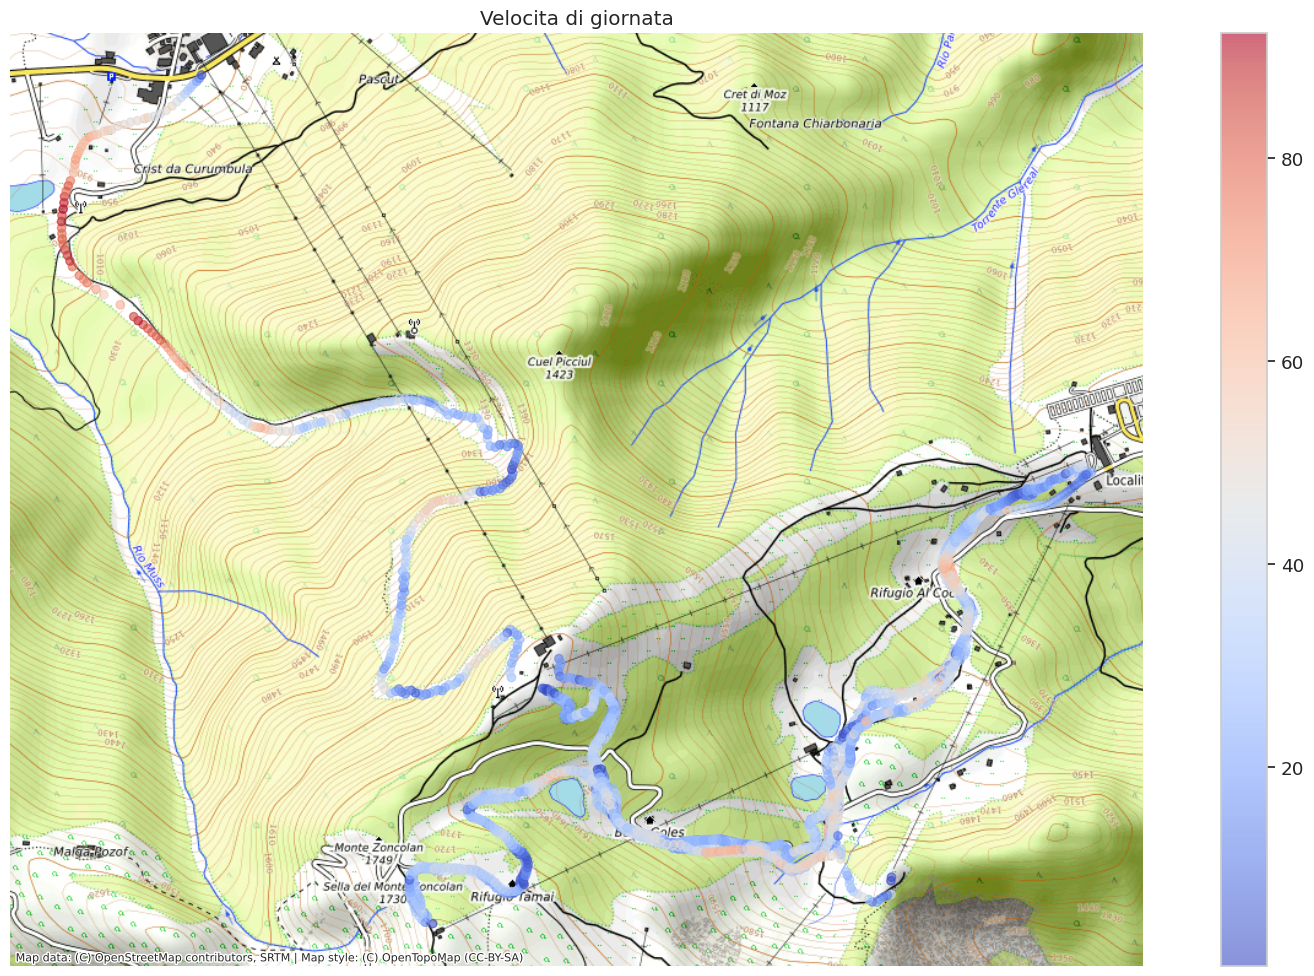

In [29]:
f, ax = plt.subplots(figsize=safe_image_size)

ax.set_title("Velocita di giornata")

sc= ax.scatter(
    gdf_discese.geometry.x, 
    gdf_discese.geometry.y, 
    c=gdf_discese['velocita'] * 3.6, 
    cmap="coolwarm", 
    #edgecolor="k",
    alpha=0.6
)

ctx.add_basemap(
                ax=ax, 
                source=ctx.providers.OpenTopoMap # OpenStreetMap.Mapnik #OpenTopoMap #https://contextily.readthedocs.io/en/latest/providers_deepdive.html
                )

plt.colorbar(
            mappable=sc,
            ax=ax,
            )

ax.set_axis_off()
ax.set_aspect('equal') ## non distorce mappa
plt.tight_layout()

plt.show()


In [30]:
## analisi discesa Ravascletto

timestart_discesa_9 = df_discese.iloc[8]['unixtime_start']
timeend_discesa_9 = df_discese.iloc[8]['unixtime_end']


gdf1_discesa_9 = gdf1[(gdf1['unixtime'] >= timestart_discesa_9) & 
                      (gdf1['unixtime'] <= timeend_discesa_9)].reset_index(drop=True)

gdf1_discesa_9['distanza_percorsa']= gdf1_discesa_9['distanza_percorsa'] -  gdf1_discesa_9.iloc[0]['distanza_percorsa']
gdf1_discesa_9['time_from_start']= gdf1_discesa_9['time_from_start'] -  gdf1_discesa_9.iloc[0]['time_from_start']

gdf1_discesa_9.head()

unixtime  latitudine  longitudine   altitudine  precisione_orizzontale  \
0  1.734876e+09   46.506367    12.930977  1750.262276                     1.9   
1  1.734876e+09   46.506481    12.930912  1748.366942                     1.8   
2  1.734876e+09   46.506598    12.930947  1746.857390                     2.3   
3  1.734876e+09   46.506714    12.930985  1743.835221                     2.8   
4  1.734876e+09   46.506830    12.931059  1740.469503                     2.0   

   precisione_verticale                         geometry  delta_tempo  \
0                   5.2   POINT (1439469.775 5861869.55)          4.0   
1                   7.6  POINT (1439462.539 5861887.988)          2.0   
2                   9.5  POINT (1439466.436 5861906.912)          2.0   
3                  10.0  POINT (1439470.666 5861925.673)          3.0   
4                   9.9  POINT (1439478.903 5861944.435)          3.0   

   distanza_orizzontale  distanza_verticale  distanza_reale  pendenza  \
0             31.655384           -2.720457       31.772067 -4.911918   
1             19.807027           -1.895334       19.897502 -5.465989   
2             19.320246           -1.509552       19.379129 -4.467624   
3             19.232582           -3.022169       19.468583 -8.930317   
4             20.490446           -3.365718       20.765029 -9.327989   

   velocita  delta_velocita  accelerazione  pendenza_radianti  \
0  7.943017        7.667158       1.916789          -0.085729   
1  9.948751        2.005734       1.002867          -0.095400   
2  9.689565       -0.259186      -0.129593          -0.077975   
3  6.489528       -3.200037      -1.066679          -0.155863   
4  6.921676        0.432149       0.144050          -0.162804   

   accelerazione_max  distanza_percorsa  time_from_start    stato  
0          -0.839973           0.000000              0.0  Discesa  
1          -0.934450          13.619071              2.0  Discesa  
2          -0.764157          26.899471              4.0  Discesa  
3          -1.522837          40.119909              7.0  Discesa  
4          -1.590062          54.210069             10.0  Discesa

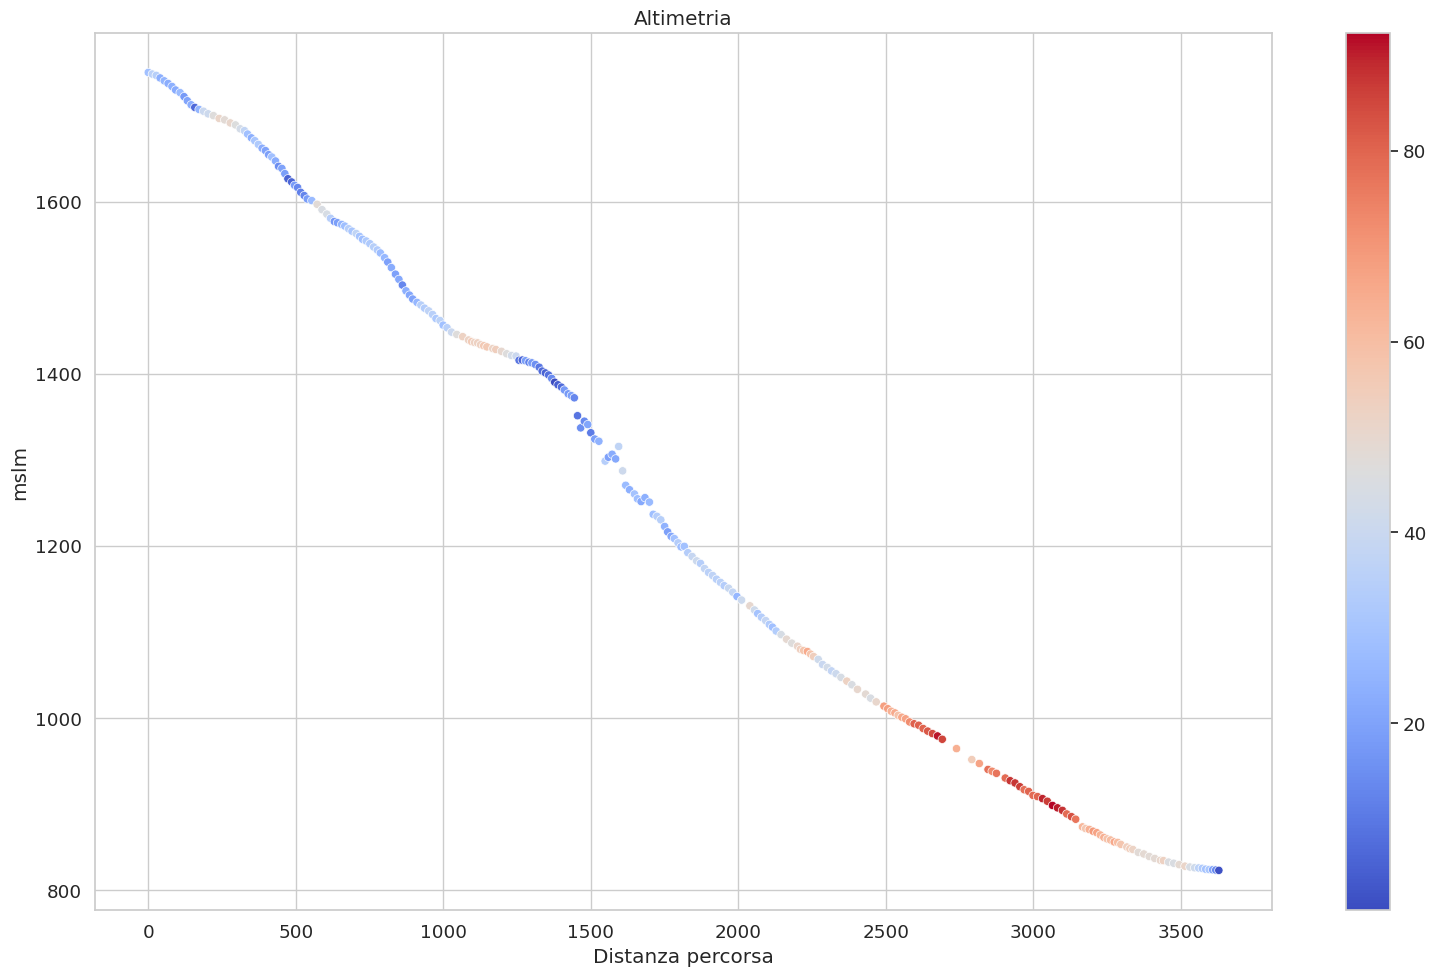

In [31]:


f, ax = plt.subplots(1, 1, figsize=safe_image_size)

ax.set_title("Altimetria")

sns.scatterplot(
    ax=ax,
    data=gdf1_discesa_9,
    y="altitudine",
    x="distanza_percorsa",
    hue= "velocita",
    palette="coolwarm"
    )

ax.set_ylabel("mslm")
ax.set_xlabel("Distanza percorsa")

norm = plt.Normalize((gdf1_discesa_9['velocita']*3.6).min(), (gdf1_discesa_9['velocita']*3.6).max())
sm = plt.cm.ScalarMappable(
                            cmap="coolwarm", 
                            norm=norm
                            )
sm.set_array([])


ax.get_legend().remove()

ax.figure.colorbar(
            mappable=sm, 
            ax=ax
        )

plt.tight_layout()
plt.show()
